In [1]:
#Add repo path to the system path
from pathlib import Path, PurePosixPath
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Libraries
from scipy.ndimage import zoom
from einops import repeat
from icecream import ic
from sklearn.model_selection import KFold
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import SimpleITK
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
from torch.nn.modules.loss import CrossEntropyLoss
from tensorboardX import SummaryWriter
import logging
from tqdm import tqdm
from importlib import import_module
import cv2 as cv

# extra imports
sys.path.append(str(repo_path / 'SAMed'))
from SAMed.utils import DiceLoss, Focal_loss
from SAMed.segment_anything import build_sam, SamPredictor
from SAMed.segment_anything import sam_model_registry
from SAMed.segment_anything.modeling import Sam

# for logging in notebook
import logging
import sys
date_strftime_format = "%m/%d/%Y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

# Some visualization

We prepare the data<br>
1. The first approach is SAMed in 2D, so the 3D slices with lesion are saved as png.
The idea is to save the 2D with this name: <br>
patient_id + slice_number + label + .png <br>

In [2]:
# define paths, get list of images and labels and split them into train and test
experiment_path = repo_path / 'experiments/SAMed_ABUS'
root_path = repo_path / 'data/challange_2023/Train'

# get list of images using metadata
metadata = pd.read_csv(root_path / 'labels.csv')

In [3]:
# get example image
idx = 0
row = metadata.iloc[idx]
# image files, replace \\ with / for windows
image_path = root_path /  row['data_path'].replace('\\', '/')
label_path = root_path / row['mask_path'].replace('\\', '/')

im = SimpleITK.GetArrayFromImage(SimpleITK.ReadImage(image_path))
label = SimpleITK.GetArrayFromImage(SimpleITK.ReadImage(label_path))
print(f'shape of image: {im.shape}')
print(f'label values: {np.unique(label)}')

shape of image: (330, 608, 865)
label values: [0 1]


In [4]:
# we need to find z values for the mask that have a label
z_values = np.unique(np.where(label)[0])
print(f'z values with label: {z_values.shape[0]}')

z values with label: 36


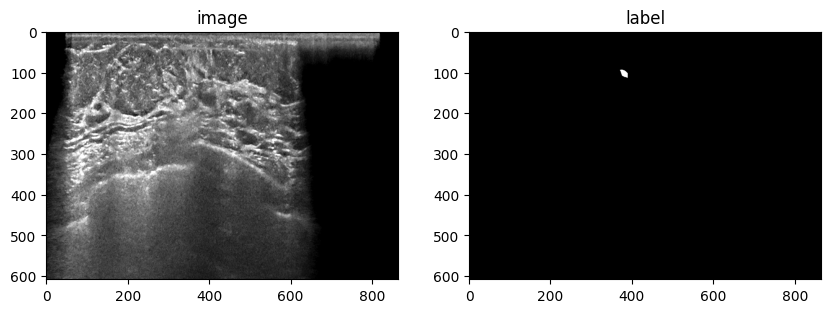

In [5]:
# show slide of image and mask in z
z = z_values[0]
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(im[z,:,:], cmap='gray')
ax[0].set_title('image')
ax[1].imshow(label[z,:,:], cmap='gray')
ax[1].set_title('label')
plt.show()

In [ ]:
# Other way of doing it
# # define paths, get list of images and labels and split them into train and test
# experiment_path = repo_path / 'experiments/SAMed_ABUS'
# root_path = repo_path / 'data/Train'
# # new images and labels
# save_dir = repo_path / 'data/Train' / 'only_lesion'

# # get list of images using metadata
# metadata = pd.read_csv(root_path / 'labels.csv')
# # image files, replace \\ with / for windows
# image_files = list(root_path /  metadata['data_path'].str.replace('\\', '/', regex=False))
# label_files = list(root_path / metadata['mask_path'].str.replace('\\', '/', regex=False))

# # get example image
# idx = 0
# im = SimpleITK.GetArrayFromImage(SimpleITK.ReadImage(image_files[idx]))
# label = SimpleITK.GetArrayFromImage(SimpleITK.ReadImage(label_files[idx]))
#  # z values valid lesion
# z_values = np.unique(np.where(label)[0])
# for z in z_values:
#     # saving path
#     save_path = save_dir / f'id_{idx}_slice_{z}_label'

# Saving pipeline for lesion-only slices

In [7]:
# define paths, get list of images and labels and split them into train and test
root_path = repo_path / 'data/challange_2023/Train'

# new images and labels
save_dir = repo_path / 'data/challange_2023' / 'only_lesion'
save_dir.mkdir(exist_ok=True)
im_dir = save_dir / 'images'
im_dir.mkdir(exist_ok=True)
label_dir = save_dir / 'labels'
label_dir.mkdir(exist_ok=True)

# get list of images using metadata
metadata = pd.read_csv(root_path / 'labels.csv')

# # get example image
# idx = 0
# row = metadata.iloc[idx]
# # image files, replace \\ with /
# image_path = root_path /  row['data_path'].replace('\\', '/')
# label_path = root_path / row['mask_path'].replace('\\', '/')
# # get image and label
# im = SimpleITK.GetArrayFromImage(SimpleITK.ReadImage(image_path))
# label = SimpleITK.GetArrayFromImage(SimpleITK.ReadImage(label_path))

#  # z values valid lesion
# z_values = np.unique(np.where(label)[0])
# for z in z_values:
#     # saving path
#     save_name = f'id_{row["case_id"]}_slice_{z}_label_{row["label"]}.mha'
#     # save image
#     SimpleITK.WriteImage(SimpleITK.GetImageFromArray(im[z,:,:]), str(im_dir / save_name))
#     # save label
#     SimpleITK.WriteImage(SimpleITK.GetImageFromArray(label[z,:,:]), str(label_dir / save_name))
    

Text(0.5, 1.0, 'label')

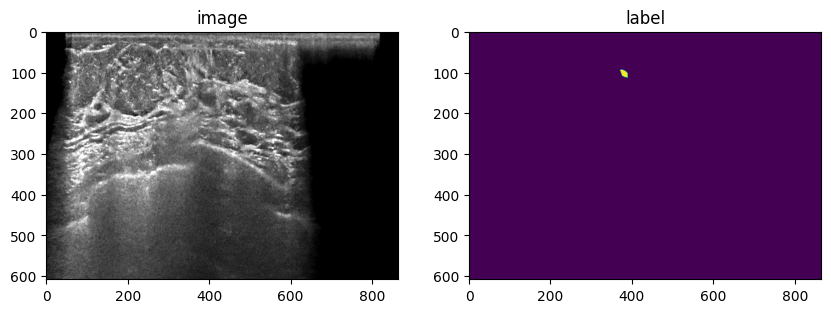

In [8]:
# read images to check they are ok, in alphabetical order
im_files = sorted(list(im_dir.glob('*.mha')))
label_files = sorted(list(label_dir.glob('*.mha')))
# show
idx = 0
label_read = SimpleITK.GetArrayFromImage(SimpleITK.ReadImage(str(label_files[idx])))
im_read = SimpleITK.GetArrayFromImage(SimpleITK.ReadImage(str(im_files[idx])))
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(im_read, cmap='gray')
ax[0].set_title('image')
ax[1].imshow(label_read)
ax[1].set_title('label')

In [12]:
len(im_files)

3170